# Homework #1

The goal of this homework is to train a simple model for predicting the duration of a ride - similar to what we did in this module.

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page),
but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records".

Download the data for January and February 2021.

Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

In [ ]:
!wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet --directory-prefix=data
!wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet --directory-prefix=data

Read the data for January. 

In [2]:
df = pd.read_parquet('data/fhv_tripdata_2021-01.parquet')

In [3]:
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [4]:
len(df)

1154112

How many records are there?

* 1054112
* **1154112**
* 1254112
* 1354112

## Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes. 

In [5]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [6]:
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013,110.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667


In [7]:
df.duration.mean()

19.167224093791006

What's the average trip duration in January?

* 15.16
* **19.16**
* 24.16
* 29.16

## Data preparation

Check the distribution of the duration variable. There are some outliers. 

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

In [8]:
df.duration.describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

In [9]:
prev_len = len(df)

In [10]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [11]:
df.duration.describe()

count    1.109826e+06
mean     1.624725e+01
std      1.155150e+01
min      1.000000e+00
25%      7.850000e+00
50%      1.323333e+01
75%      2.146667e+01
max      6.000000e+01
Name: duration, dtype: float64

In [12]:
len(df)

1109826

In [13]:
print(f'Number of dropped records: {prev_len - len(df)}')

Number of dropped records: 44286


## Q3. Missing values

The features we'll use for our model are the pickup and dropoff location IDs. 

But they have a lot of missing values there. Let's replace them with "-1".

In [14]:
na_fraction = df.PUlocationID.isna().sum() / len(df) * 100
na_fraction

83.52732770722618

In [15]:
df = df.fillna(-1)

In [16]:
df.isna().sum()

dispatching_base_num      0
pickup_datetime           0
dropOff_datetime          0
PUlocationID              0
DOlocationID              0
SR_Flag                   0
Affiliated_base_number    0
duration                  0
dtype: int64

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

* 53%
* 63%
* 73%
* **83%**

## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer 
* Get a feature matrix from it

In [17]:
categorical = ['PUlocationID', 'DOlocationID']

In [18]:
df[categorical] = df[categorical].astype(str)

In [19]:
train_dicts = df[categorical].to_dict(orient='records')

In [20]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [21]:
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (1109826, 525)


What's the dimensionality of this matrix? (The number of columns).

* 2
* 152
* 352
* **525**
* 725

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters 
* Calculate the RMSE of the model on the training data

In [22]:
target = 'duration'
y_train = df[target].values

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

Train RMSE: 10.528519397404155


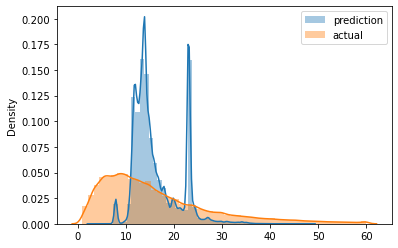

In [24]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend();

What's the RMSE on train?

* 5.52
* **10.52**
* 15.52
* 20.52

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021). 

In [25]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.dropOff_datetime = pd.to_datetime(df.dropOff_datetime)
        df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [26]:
df_val = read_dataframe('./data/fhv_tripdata_2021-02.parquet')

In [27]:
df_val.shape

(990113, 8)

In [28]:
val_dicts = df_val[categorical].to_dict(orient='records')

X_val = dv.transform(val_dicts)
y_val = df_val[target].values

In [29]:
y_pred = lr.predict(X_val)

print(f'Val RMSE: {mean_squared_error(y_val, y_pred, squared=False)}')

Val RMSE: 11.364115310279333


What's the RMSE on validation?

* 6.01
* **11.01**
* 16.01
* 21.01